In [1]:
import os, math, time, random, gc
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, Model
import re

In [2]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

PIVOTED_FILE = "pivoted_data.parquet"
ANOMALY_WINDOWS_FILE = "anomaly_windows.csv"
OUT_DIR = os.path.join("userData", "pivoted_paper_baseline_timesnet_viz")
os.makedirs(OUT_DIR, exist_ok=True)


SEQ_LEN = 32
W_LONG, W_SHORT = 30, 2
ROUND_RES = "5T"
EVENT_GAP_MINUTES = 15
PCT_PROB = 0.05

EPOCHS = 40
BATCH_SIZE = 64
LR = 1e-4


THR_GRID = np.linspace(0.98, 0.9995, 200)  

In [3]:
def read_parquet_smart(path, time_col="interval_start"):
    df = pd.read_parquet(path) if str(path).endswith(".parquet") else pd.read_csv(path)
    if time_col in df.columns and not isinstance(df.index, pd.DatetimeIndex):
        df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
        df = df.sort_values(time_col).set_index(time_col)
    if isinstance(df.index, pd.DatetimeIndex) and df.index.year.max() < 1990:
        ns = df.index.view("int64")
        maxv = float(ns.max())
        if maxv < 1e12:
            scale = 1_000_000_000
        elif maxv < 1e15:
            scale = 1_000_000
        elif maxv < 1e18:
            scale = 1_000
        else:
            scale = 1
        df = df.copy()
        df.index = pd.to_datetime(ns * scale, unit="ns")
    return df

def add_time_features(index):
    t = pd.Series(index.view("int64") // 10**9, index=index)
    day = 24 * 3600
    week = 7 * day
    return pd.DataFrame({
        "sin_day": np.sin(2 * np.pi * (t % day) / day),
        "cos_day": np.cos(2 * np.pi * (t % day) / day),
        "sin_week": np.sin(2 * np.pi * (t % week) / week),
        "cos_week": np.cos(2 * np.pi * (t % week) / week),
    }, index=index).astype(np.float32)

def make_sequences(df_values, L=1):
    arr = df_values.values
    if L == 1:
        return arr[:, None, :]
    n = len(arr) - L + 1
    return np.stack([arr[i:i+L] for i in range(n)], axis=0)

In [21]:
NAB_PROFILES = {
    "standard": {"TP": 1.0, "FN": -1.0, "FP": -0.11, "TN": 0.0},
    "low_fp":  {"TP": 1.0, "FN": -1.0, "FP": -0.22, "TN": 0.0},
    "low_fn": {"TP": 1.0, "FN": -2.0, "FP": -0.11, "TN": 0.0}
}

def scaled_sigmoid(x, lo, hi, slope=5.0):
    v = 1.0 / (1.0 + np.exp(-slope * x))
    return lo + (hi - lo) * v

def _tp_score(time_hit, start, end, tp_weight):
    time_hit = pd.Timestamp(time_hit)
    start = pd.Timestamp(start)
    end = pd.Timestamp(end)
    L = (end - start).total_seconds()
    if L <= 0:
        return float(tp_weight)
    if time_hit <= start + pd.Timedelta(microseconds=1):
        return float(tp_weight)
    r = (time_hit - start).total_seconds() / L
    r = np.clip(r, 0.0, 1.0)
    x = 1.0 - 2.0 * r
    return float(scaled_sigmoid(x, 0.0, float(tp_weight)))

def _fp_penalty(time_hit, windows, fp_weight):
    if not windows:
        return float(fp_weight)
    dists = []
    lens = []
    for (s, e) in windows:
        if s <= time_hit <= e:
            dists.append(0.0)
        elif time_hit < s:
            dists.append((s - time_hit).total_seconds())
        else:
            dists.append((time_hit - e).total_seconds())
        lens.append((e - s).total_seconds())
    d = float(min(dists))
    mean_len = float(np.mean(lens)) if len(lens) > 0 else 60.0
    z = d / max(mean_len, 1.0)
    val = scaled_sigmoid(z, float(fp_weight), 0.0)
    return float(min(0.0, val))

def read_gt_windows(csv_path, start_hint="start", end_hint="end"):
    gt = pd.read_csv(csv_path)
    s_cols = [c for c in gt.columns if start_hint in c.lower()]
    e_cols = [c for c in gt.columns if end_hint in c.lower()]
    if not s_cols or not e_cols:
        raise ValueError("Could not find start/end columns in anomaly_windows.csv")
    s_col = s_cols[0]
    e_col = e_cols[0]
    df = pd.DataFrame({
        "anomaly_start": pd.to_datetime(gt[s_col].astype(str).str.replace(r'([+-]\d{2}:?\d{2}|Z)$','', regex=True), errors="coerce"),
        "anomaly_end":   pd.to_datetime(gt[e_col].astype(str).str.replace(r'([+-]\d{2}:?\d{2}|Z)$','', regex=True), errors="coerce")
    }).dropna().reset_index(drop=True)
    return df

def mask_to_event_times(pred_mask, timestamps, event_gap_minutes=15, pct_prob=0.0):
    timestamps = np.asarray(timestamps)
    pm = np.asarray(pred_mask).astype(bool)
    if pct_prob > 0.0:
        cutoff = timestamps[0] + (timestamps[-1] - timestamps[0]) * pct_prob
        pm = pm & (timestamps >= cutoff)
    if not pm.any():
        return []
    shifted = np.concatenate(([False], pm[:-1]))
    edges = np.where(pm & (~shifted))[0]
    if len(edges) == 0:
        edges = np.array([np.where(pm)[0][0]])
    events = [pd.to_datetime(timestamps[edges[0]])]
    gap = pd.Timedelta(minutes=event_gap_minutes)
    for idx in edges[1:]:
        t = pd.to_datetime(timestamps[idx])
        if (t - events[-1]) >= gap:
            events.append(t)
    return events

def nab_score_from_mask(pred_mask, gt_windows_df, timestamps, profile="standard", event_gap_minutes=15, pct_prob=0.0):
    if profile not in NAB_PROFILES:
        raise ValueError("Unknown NAB profile: " + str(profile))
    prof = NAB_PROFILES[profile]
    TPw, FNw, FPw = prof["TP"], prof["FN"], prof["FP"]
    wins = [(pd.Timestamp(r["anomaly_start"]), pd.Timestamp(r["anomaly_end"])) for _, r in gt_windows_df.iterrows()]
    events = mask_to_event_times(pred_mask, timestamps, event_gap_minutes, pct_prob)
    score = 0.0
    TP = 0
    FP = 0
    used = [False] * len(wins)
    for ev in events:
        hit = -1
        for i, (s, e) in enumerate(wins):
            if (not used[i]) and (s <= ev <= e):
                hit = i
                break
        if hit >= 0:
            score += _tp_score(ev, wins[hit][0], wins[hit][1], TPw)
            used[hit] = True
            TP += 1
        else:
            score += _fp_penalty(ev, wins, FPw)
            FP += 1
    FN = sum(not u for u in used)
    score += FNw * FN
    perfect = TPw * len(wins)
    null = FNw * len(wins)
    if np.isclose(perfect, null):
        normalized = 0.0
    else:
        normalized = 100.0 * (score - null) / (perfect - null)
    return float(normalized), {"TP": int(TP), "FN": int(FN), "FP": int(FP)}

def likelihood_scores_from_s(err, W=30, Wp=2):
    T = len(err)
    L = np.zeros(T)
    eps = 1e-8
    for t in range(T):
        a = max(0, t - W + 1)
        b = t + 1
        a2 = max(0, t - Wp + 1)
        long_window = err[a:b]
        short_window = err[a2:b]
        mu = long_window.mean()
        std = long_window.std(ddof=1) if (b - a) > 1 else eps
        mu_s = short_window.mean()
        z = (mu_s - mu) / (std + eps)
        L[t] = norm.cdf(z)
    return L

In [5]:
def shaped_alerts(Ls, thr, cd, k_of_m=(2,3)):
    k,m = k_of_m
    above = (Ls >= thr)
    n = len(above)
    persisted = np.zeros_like(above)
    for i in range(n):
        persisted[i] = (above[max(0, i-m+1):i+1].sum() >= k)
    trig = np.zeros_like(above)
    i=0
    while i<n:
        if persisted[i]:
            trig[i] = 1
            i += cd
        else:
            i += 1
    return trig.astype(bool)

In [6]:

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model


def gelu_fn(x):
    return 0.5 * x * (1.0 + tf.tanh(tf.sqrt(2.0 / tf.constant(np.pi, dtype=x.dtype)) * (x + 0.044715 * tf.pow(x, 3))))
GELU = layers.Activation(gelu_fn)


def FFT_for_Period_tf(x, k=2):
    # x: [B, T, C]
    B = tf.shape(x)[0]
    T = tf.shape(x)[1]
    C = tf.shape(x)[2]

    
    x_t = tf.transpose(x, perm=[0, 2, 1])            
    xf = tf.signal.rfft(x_t)                         
    xf = tf.transpose(xf, perm=[0, 2, 1])            
    amp = tf.abs(xf)                                 

    freq_mean = tf.reduce_mean(amp, axis=[0, 2])    
    freq_len = tf.shape(freq_mean)[0]

    def degenerate():
        periods = tf.ones([k], dtype=tf.int32)
        period_weight = tf.zeros([B, k], dtype=tf.float32)
        return periods, period_weight

    def normal():
        freq_mean_non_dc = tf.concat([tf.constant([0.0], dtype=freq_mean.dtype), freq_mean[1:]], axis=0)
        k_eff = tf.minimum(k, tf.maximum(freq_len - 1, 1))
        topk = tf.math.top_k(freq_mean_non_dc, k=tf.maximum(1, k_eff))
        top_idx = topk.indices
        top_idx_safe = tf.cast(top_idx, tf.int32)
        top_idx_safe = tf.clip_by_value(top_idx_safe, 0, freq_len - 1)

        idx_for_div = tf.where(tf.equal(top_idx_safe, 0), tf.ones_like(top_idx_safe), top_idx_safe)
        periods = tf.math.floordiv(tf.cast(T, tf.int32), tf.maximum(idx_for_div, 1))

        per_sample = tf.reduce_mean(amp, axis=2)   
        period_weight = tf.gather(per_sample, top_idx_safe, axis=1)  

        cond_pad = tf.less(k_eff, k)
        def do_pad():
            pad_n = k - k_eff
            last_p = periods[-1:]                          
            last_p_tiled = tf.tile(last_p, [pad_n])      
            periods_padded = tf.concat([periods, tf.cast(last_p_tiled, periods.dtype)], axis=0)

            last_w = period_weight[:, -1:]                
            pad_w = tf.tile(last_w, [1, pad_n])           
            period_weight_padded = tf.concat([period_weight, pad_w], axis=1)
            return periods_padded, period_weight_padded
        def no_pad():
            return periods, period_weight
        periods_out, period_weight_out = tf.cond(cond_pad, do_pad, no_pad)

        period_weight_out = tf.cast(period_weight_out, tf.float32)
        periods_out = tf.cast(periods_out, tf.int32)
        return periods_out, period_weight_out

    periods, period_weight = tf.cond(tf.less_equal(freq_len, 1), degenerate, normal)
    return periods, period_weight  



def circular_pad_1d(x, pad):
    if pad == 0:
        return x
    left = x[:, -pad:, :]
    right = x[:, :pad, :]
    return tf.concat([left, x, right], axis=1)

class TokenEmbeddingTF(layers.Layer):
    def __init__(self, c_in, d_model, kernel_size=3, **kwargs):
        super().__init__(**kwargs)
        self.pad = kernel_size // 2
        self.conv = layers.Conv1D(filters=d_model, kernel_size=kernel_size, padding='valid',
                                  use_bias=False, kernel_initializer="he_normal")

    def call(self, x, training=None):
        x_p = circular_pad_1d(x, self.pad)
        return self.conv(x_p)

class PositionalEmbeddingTF(layers.Layer):
    def __init__(self, d_model, max_len=5000, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.max_len = max_len
        pe = np.zeros((self.max_len, self.d_model), dtype=np.float32)
        position = np.arange(0, self.max_len)[:, np.newaxis].astype(np.float32)
        div_term = np.exp(np.arange(0, self.d_model, 2, dtype=np.float32) * -(np.log(10000.0) / self.d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        self.pe = tf.constant(pe)  

    def call(self, x, training=None):
        T = tf.shape(x)[1]
        pos_slice = self.pe[:T, :]               
        pos_batched = tf.expand_dims(pos_slice, axis=0)
        pos_batched = tf.tile(pos_batched, [tf.shape(x)[0], 1, 1])
        return pos_batched

class TemporalEmbeddingTF(layers.Layer):
    def __init__(self, d_model, embed_type='fixed', freq='h', **kwargs):
        super().__init__(**kwargs)
        minute_size = 4
        hour_size = 24
        weekday_size = 7
        day_size = 32
        month_size = 13
        self.use_minute = (freq == 't')
        Emb = layers.Embedding
        if self.use_minute:
            self.minute_embed = Emb(input_dim=minute_size, output_dim=d_model)
        self.hour_embed = Emb(input_dim=hour_size, output_dim=d_model)
        self.weekday_embed = Emb(input_dim=weekday_size, output_dim=d_model)
        self.day_embed = Emb(input_dim=day_size, output_dim=d_model)
        self.month_embed = Emb(input_dim=month_size, output_dim=d_model)

    def call(self, x, training=None):
        if x is None:
            return 0.0
        x = tf.cast(x, tf.int32)
        minute_x = self.minute_embed(x[:, :, 4]) if self.use_minute else 0.0
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])
        return hour_x + weekday_x + day_x + month_x + minute_x

class TimeFeatureEmbeddingTF(layers.Layer):
    def __init__(self, d_model, freq='h', **kwargs):
        super().__init__(**kwargs)
        freq_map = {'h': 4, 't': 5, 's': 6, 'm': 1, 'a': 1, 'w': 2, 'd': 3, 'b': 3}
        d_inp = freq_map.get(freq, 4)
        self.proj = layers.TimeDistributed(layers.Dense(d_model, use_bias=False))

    def call(self, x, training=None):
        if x is None:
            return 0.0
        return self.proj(x, training=training)



class InceptionBlockV1TF(layers.Layer):
    def __init__(self, in_channels, out_channels, num_kernels=6, **kwargs):
        super().__init__(**kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_kernels = int(num_kernels)
        self.kernels = []
        for i in range(self.num_kernels):
            k = 2 * i + 1
            conv = layers.Conv2D(filters=self.out_channels, kernel_size=(1, k), padding='same', activation=None,
                                 kernel_initializer="he_normal")
            self.kernels.append(conv)

    def call(self, x, training=None):
        res_list = []
        for conv in self.kernels:
            res_list.append(conv(x))
        stacked = tf.stack(res_list, axis=-1)  
        out = tf.reduce_mean(stacked, axis=-1) 
        return out

class TimesBlockTF(layers.Layer):
    def __init__(self, configs, **kwargs):
        super().__init__(**kwargs)
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.k = int(configs.top_k)
        self.d_model = configs.d_model
        self.d_ff = configs.d_ff
        self.num_kernels = int(configs.num_kernels)

        
        self.incep1 = InceptionBlockV1TF(self.d_model, self.d_ff, num_kernels=self.num_kernels)
        self.incep2 = InceptionBlockV1TF(self.d_ff, self.d_model, num_kernels=self.num_kernels)
        self.gelu = GELU
        self.layer_norm = layers.LayerNormalization(axis=-1)

    def call(self, x, training=None):
    
        B = tf.shape(x)[0]
        T = tf.shape(x)[1]
        N = tf.shape(x)[2]

        periods, period_weight = FFT_for_Period_tf(x, self.k)  
        period_weight = tf.cast(period_weight, tf.float32)

        res_list = []
        full_len = self.seq_len + self.pred_len

        for i in range(self.k):
            p = tf.cast(periods[i], tf.int32)
            p = tf.maximum(p, 1)
            mod = tf.math.floormod(full_len, p)
            needed = tf.cond(tf.equal(mod, 0), lambda: 0, lambda: p - mod)

            def do_pad():
                pad_tensor = tf.zeros([B, needed, N], dtype=x.dtype)
                return tf.concat([x, pad_tensor], axis=1)
            out = tf.cond(tf.equal(needed, 0), lambda: x, do_pad)

            new_len = tf.shape(out)[1]
            H = new_len // p
            W = p

            out_resh = tf.reshape(out, (B, H, W, N))   
            out_c = self.incep1(out_resh, training=training)
            out_c = self.gelu(out_c)
            out_c = self.incep2(out_c, training=training)
            out_back = tf.reshape(out_c, (B, new_len, N))
            out_back = out_back[:, :full_len, :]
            res_list.append(out_back)

        res_stack = tf.stack(res_list, axis=-1)  

        w = tf.nn.softmax(period_weight, axis=1)  
        w_exp = tf.reshape(w, (B, 1, 1, self.k))
        w_exp = tf.tile(w_exp, [1, full_len, N, 1])

        out_agg = tf.reduce_sum(res_stack * w_exp, axis=-1) 
        out_final = out_agg + x
        out_final = self.layer_norm(out_final)
        return out_final



class DataEmbeddingTF(layers.Layer):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1, max_pos_len=5000, **kwargs):
        super().__init__(**kwargs)
        self.value_embedding = TokenEmbeddingTF(c_in=c_in, d_model=d_model, kernel_size=3)
        self.position_embedding = PositionalEmbeddingTF(d_model=d_model, max_len=max_pos_len)
        if embed_type != 'timeF':
            self.temporal_embedding = TemporalEmbeddingTF(d_model=d_model, embed_type=embed_type, freq=freq)
        else:
            self.temporal_embedding = TimeFeatureEmbeddingTF(d_model=d_model, freq=freq)
        self.dropout = layers.Dropout(rate=dropout)

    def call(self, x, x_mark=None, training=None):
        value = self.value_embedding(x, training=training)
        pos = self.position_embedding(x, training=training)
        if x_mark is None:
            out = value + pos
        else:
            temp = self.temporal_embedding(x_mark, training=training)
            out = value + temp + pos
        return self.dropout(out, training=training)



class TimesNetModel(Model):
    def __init__(self, configs, **kwargs):
        super().__init__(**kwargs)
        self.configs = configs
        self.task_name = configs.task_name
        self.seq_len = configs.seq_len
        self.label_len = configs.label_len
        self.pred_len = configs.pred_len
        self.e_layers = configs.e_layers

        self.model_blocks = [TimesBlockTF(configs) for _ in range(self.e_layers)]
        self.enc_embedding = DataEmbeddingTF(configs.enc_in, configs.d_model, embed_type=getattr(configs, 'embed', 'fixed'),
                                            freq=getattr(configs, 'freq', 'h'), dropout=getattr(configs, 'dropout', 0.1))
        self.layer_norm = layers.LayerNormalization(axis=-1)

       
        if self.task_name in ('long_term_forecast', 'short_term_forecast'):
            
            self.predict_linear = layers.Dense(self.pred_len + self.seq_len)
            self.projection = layers.TimeDistributed(layers.Dense(configs.c_out, use_bias=True))
        elif self.task_name in ('imputation', 'anomaly_detection'):
            self.projection = layers.TimeDistributed(layers.Dense(configs.c_out, use_bias=True))
        elif self.task_name == 'classification':
            self.act = layers.Activation(gelu_fn)
            self.dropout = layers.Dropout(getattr(configs, 'dropout', 0.1))
            self.projection = layers.Dense(configs.num_class)

    def _denormalize(self, dec_out, means, stdev):
        
        L = tf.shape(dec_out)[1]
        st = tf.reshape(stdev[:, 0, :], (tf.shape(dec_out)[0], 1, tf.shape(dec_out)[2]))
        mn = tf.reshape(means[:, 0, :], (tf.shape(dec_out)[0], 1, tf.shape(dec_out)[2]))
        dec = dec_out * st + mn
        return dec

    def forecast(self, x_enc, x_mark_enc, x_dec=None, x_mark_dec=None):
        means = tf.reduce_mean(x_enc, axis=1, keepdims=True)
        x_norm = x_enc - means
        stdev = tf.sqrt(tf.math.reduce_variance(x_norm, axis=1, keepdims=True) + 1e-5)
        x_norm = x_norm / stdev

        enc_out = self.enc_embedding(x_norm, x_mark_enc, training=False) 
        
        enc_t = tf.transpose(enc_out, [0, 2, 1])
        enc_t = self.predict_linear(enc_t)  
        enc_out = tf.transpose(enc_t, [0, 2, 1])  

        for b in self.model_blocks:
            enc_out = self.layer_norm(b(enc_out))

        dec_out = self.projection(enc_out)
        dec_out = self._denormalize(dec_out, means, stdev)
        return dec_out

    def imputation(self, x_enc, x_mark_enc, x_dec=None, x_mark_dec=None, mask=None):
        
        mask_f = tf.cast(mask, x_enc.dtype) if mask is not None else tf.ones_like(x_enc[:, :, 0])
        denom = tf.reduce_sum(tf.cast(mask_f == 1, x_enc.dtype), axis=1, keepdims=True)
        means = tf.reduce_sum(x_enc, axis=1, keepdims=True) / tf.maximum(denom, 1.0)
        means = tf.stop_gradient(means)
        x_norm = x_enc - means
        if mask is not None:
            x_norm = tf.where(tf.expand_dims(mask_f == 1, -1), x_norm, tf.zeros_like(x_norm))
        stdev = tf.sqrt(tf.reduce_sum(x_norm * x_norm, axis=1, keepdims=True) / tf.maximum(denom, 1.0) + 1e-5)
        stdev = tf.stop_gradient(stdev)
        x_norm = x_norm / stdev

        enc_out = self.enc_embedding(x_norm, x_mark_enc)
        for b in self.model_blocks:
            enc_out = self.layer_norm(b(enc_out))
        dec_out = self.projection(enc_out)
        dec_out = self._denormalize(dec_out, means, stdev)
        return dec_out

    def anomaly_detection(self, x_enc):
        means = tf.reduce_mean(x_enc, axis=1, keepdims=True)
        x_norm = x_enc - means
        stdev = tf.sqrt(tf.math.reduce_variance(x_norm, axis=1, keepdims=True) + 1e-5)
        x_norm = x_norm / stdev

        enc_out = self.enc_embedding(x_norm, None)
        for b in self.model_blocks:
            enc_out = self.layer_norm(b(enc_out))
        dec_out = self.projection(enc_out)
        dec_out = self._denormalize(dec_out, means, stdev)
        return dec_out

    def classification(self, x_enc, x_mark_enc):
        enc_out = self.enc_embedding(x_enc, None)
        for b in self.model_blocks:
            enc_out = self.layer_norm(b(enc_out))
        output = self.act(enc_out)
        output = self.dropout(output)
        if x_mark_enc is not None:
            
            output = output * tf.expand_dims(x_mark_enc, -1)
        output = tf.reshape(output, (tf.shape(output)[0], -1))
        output = self.projection(output)
        return output

    def call(self, x_enc, x_mark_enc=None, x_dec=None, x_mark_dec=None, mask=None, training=None):
        if self.task_name in ('long_term_forecast', 'short_term_forecast'):
            dec = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
            return dec[:, -self.pred_len:, :]
        if self.task_name == 'imputation':
            return self.imputation(x_enc, x_mark_enc, x_dec, x_mark_dec, mask)
        if self.task_name == 'anomaly_detection':
            return self.anomaly_detection(x_enc)
        if self.task_name == 'classification':
            return self.classification(x_enc, x_mark_enc)
        return None


In [7]:

print("Loading data from:", PIVOTED_FILE)
df = read_parquet_smart(PIVOTED_FILE, time_col="interval_start")

Loading data from: pivoted_data.parquet


In [8]:
include_patterns = [r"(5xx|_5\d\d_)", r"_count$"]
compiled = [re.compile(p, re.I) for p in include_patterns]
feature_cols = [c for c in df.columns if all(p.search(c) for p in compiled)]
print("Selected feature columns:", len(feature_cols))
if len(feature_cols) == 0:
    raise ValueError("No features matched the selection patterns.")

five_xx_cols = [c for c in df.columns if re.search(r"5xx|_5\d\d_", c, re.I) and c.endswith("_count")]
df["sum_5xx_count"] = df[five_xx_cols].fillna(0).sum(axis=1)

X = df[feature_cols].fillna(0).astype(np.float32)
X = pd.concat([X, add_time_features(X.index)], axis=1)

TRAIN_START, TRAIN_END = pd.Timestamp("2024-01-26"), pd.Timestamp("2024-02-29 23:59:59")
TEST_START, TEST_END = pd.Timestamp("2024-03-01"), pd.Timestamp("2024-05-31 23:59:59")

train_df = X[(X.index >= TRAIN_START) & (X.index <= TRAIN_END)].copy()
test_df  = X[(X.index >= TEST_START) & (X.index <= TEST_END)].copy()
print("Train rows:", len(train_df), "Test rows:", len(test_df))

Selected feature columns: 2406
Train rows: 10074 Test rows: 26487


In [9]:

gt_all = pd.read_csv(ANOMALY_WINDOWS_FILE)
s_cols = [c for c in gt_all.columns if 'start' in c.lower()]
e_cols = [c for c in gt_all.columns if 'end' in c.lower()]
if not s_cols or not e_cols:
    raise ValueError("Could not find start/end columns in anomaly_windows.csv")
gt_df_raw = pd.DataFrame({
    'anomaly_start': pd.to_datetime(gt_all[s_cols[0]].astype(str).str.replace(r'([+-]\d{2}:?\d{2}|Z)$','', regex=True), errors='coerce'),
    'anomaly_end':   pd.to_datetime(gt_all[e_cols[0]].astype(str).str.replace(r'([+-]\d{2}:?\d{2}|Z)$','', regex=True), errors='coerce')
}).dropna().reset_index(drop=True)

gt_in_test = gt_df_raw[(gt_df_raw['anomaly_end'] >= test_df.index[0]) & (gt_df_raw['anomaly_start'] <= test_df.index[-1])].reset_index(drop=True)
print("GT windows total:", len(gt_df_raw), "GT inside test:", len(gt_in_test))

GT windows total: 25 GT inside test: 18


In [10]:

mask_train_anomalies = True
if mask_train_anomalies:
    train_idx = train_df.index
    keep_mask = np.ones(len(train_idx), dtype=bool)
    for s,e in gt_df_raw.itertuples(index=False):
        keep_mask &= ~((train_idx >= s) & (train_idx <= e))
    removed = len(train_df) - keep_mask.sum()
    train_df = train_df.loc[keep_mask]
    print("Rows removed from training due to masking GT windows:", removed)

Rows removed from training due to masking GT windows: 100


In [11]:

scaler = MinMaxScaler()
scaler.fit(train_df)
train_scaled = pd.DataFrame(scaler.transform(train_df), index=train_df.index, columns=train_df.columns)
test_scaled = pd.DataFrame(scaler.transform(test_df), index=test_df.index, columns=test_df.columns)

In [12]:

Xtr_seq = make_sequences(train_scaled, SEQ_LEN)
Xte_seq = make_sequences(test_scaled, SEQ_LEN)
print("Train seq shape:", Xtr_seq.shape, "Test seq shape:", Xte_seq.shape)

input_dim = Xtr_seq.shape[-1]

Train seq shape: (9943, 32, 2410) Test seq shape: (26456, 32, 2410)


In [13]:

from types import SimpleNamespace
configs = SimpleNamespace()
configs.task_name = 'anomaly_detection'
configs.seq_len = SEQ_LEN; configs.label_len = 0; configs.pred_len = 0
configs.top_k = 2
configs.d_model = 128; configs.d_ff = 512; configs.num_kernels = 4; configs.e_layers = 2
configs.enc_in = input_dim; configs.c_out = input_dim
configs.embed = 'fixed'; configs.freq = 'h'; configs.dropout = 0.1
configs.num_class = None

In [14]:

timesnet_model = TimesNetModel(configs)  
_dummy = tf.zeros((1, SEQ_LEN, input_dim), dtype=tf.float32)
_ = timesnet_model(_dummy, training=False)  
timesnet_model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss='mse')
print("TimesNet model built.")

TimesNet model built.


In [15]:

history = timesnet_model.fit(Xtr_seq, Xtr_seq, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_split=0.1, verbose=1)
timesnet_model.save_weights(os.path.join(OUT_DIR, "timesnet_weights.tf"))

Train on 8948 samples, validate on 995 samples
Epoch 1/40
8948/8948 [==============================] - 37s 4ms/sample - loss: 3.4910e-04 - val_loss: 3.1588e-04
Epoch 2/40
8948/8948 [==============================] - 28s 3ms/sample - loss: 2.9605e-04 - val_loss: 2.8951e-04
Epoch 3/40
8948/8948 [==============================] - 28s 3ms/sample - loss: 2.5212e-04 - val_loss: 2.6737e-04
Epoch 4/40
8948/8948 [==============================] - 28s 3ms/sample - loss: 2.1807e-04 - val_loss: 2.4595e-04
Epoch 5/40
8948/8948 [==============================] - 27s 3ms/sample - loss: 1.9209e-04 - val_loss: 2.2835e-04
Epoch 6/40
8948/8948 [==============================] - 27s 3ms/sample - loss: 1.7212e-04 - val_loss: 2.1405e-04
Epoch 7/40
8948/8948 [==============================] - 28s 3ms/sample - loss: 1.5623e-04 - val_loss: 2.0247e-04
Epoch 8/40
8948/8948 [==============================] - 28s 3ms/sample - loss: 1.4323e-04 - val_loss: 1.9300e-04
Epoch 9/40
8948/8948 [===========================

In [16]:

recon = timesnet_model.predict(Xte_seq, batch_size=max(1,BATCH_SIZE), verbose=0)
squared = (recon - Xte_seq)**2
s_t = squared.mean(axis=(1,2)).astype(np.float32) 
L_raw = likelihood_scores_from_s(s_t, W=W_LONG, Wp=W_SHORT)


all_test_index = pd.to_datetime(test_scaled.index)
try:
    all_test_index = all_test_index.tz_localize(None)
except Exception:
    pass
seq_timestamps = all_test_index[SEQ_LEN - 1 : SEQ_LEN - 1 + len(L_raw)]
seq_timestamps = seq_timestamps.round(ROUND_RES)

scores_df = pd.DataFrame({"timestamp": seq_timestamps, "anomaly_score": L_raw}).set_index("timestamp")

In [17]:

gt_df = gt_in_test.copy()
gt_df['anomaly_start'] = pd.to_datetime(gt_df['anomaly_start']).dt.tz_localize(None)
gt_df['anomaly_end'] = pd.to_datetime(gt_df['anomaly_end']).dt.tz_localize(None)
gt_df['start_rounded'] = gt_df['anomaly_start'].dt.round(ROUND_RES)
gt_df['end_rounded'] = gt_df['anomaly_end'].dt.round(ROUND_RES)
t0, t1 = seq_timestamps[0], seq_timestamps[-1]
gt_df['start_clipped'] = gt_df['start_rounded'].clip(lower=t0, upper=t1)
gt_df['end_clipped'] = gt_df['end_rounded'].clip(lower=t0, upper=t1)
gt_df = gt_df[gt_df['start_clipped'] <= gt_df['end_clipped']].reset_index(drop=True)

gt_series = pd.Series(0, index=seq_timestamps)
for _, r in gt_df.iterrows():
    s, e = r['start_clipped'], r['end_clipped']
    mask = (gt_series.index >= s) & (gt_series.index <= e)
    if mask.any(): gt_series.loc[mask] = 1

In [22]:
n = len(L_raw)
val_n = max(1, int(0.2 * n))
val_idx = np.arange(val_n)
val_ts = seq_timestamps[val_idx]
gt_val = gt_df[(gt_df['anomaly_end'] >= val_ts[0]) & (gt_df['anomaly_start'] <= val_ts[-1])].reset_index(drop=True)
best = {"score": -1}
L_s_candidates = {}


for alpha in [0.2, 0.3, 0.5]:
    Ls = np.copy(L_raw)
   
    if alpha > 0:
        out = np.empty_like(Ls)
        acc = 0.0
        for i,v in enumerate(Ls):
            acc = alpha*v + (1-alpha)*acc if i else v
            out[i] = acc
        Ls = out
    L_val = Ls[:val_n]
    for k_of_m in [(2,3),(3,5)]:
        for cd in [12, 24, 36, 72]:
            for thr in THR_GRID:
                pred_val = shaped_alerts(L_val, thr, cd, k_of_m)
                s, _ = nab_score_from_mask(pred_val, gt_val.assign(anomaly_start=gt_val['anomaly_start'], anomaly_end=gt_val['anomaly_end']), val_ts, profile='standard', event_gap_minutes=cd, pct_prob=PCT_PROB)
                if s > best["score"]:
                    best = {"score": s, "alpha": alpha, "k_of_m": k_of_m, "cd": cd, "thr": thr}

print("[TUNE] best on val ->", best)

if best["score"] < 0:
    best = {"alpha":0.3, "k_of_m":(2,3), "cd":24, "thr":0.995}


alpha = best["alpha"]
if alpha > 0:
    L_s = np.copy(L_raw)
    out = np.empty_like(L_s)
    acc = 0.0
    for i,v in enumerate(L_s):
        acc = alpha*v + (1-alpha)*acc if i else v
        out[i] = acc
    L_s = out
else:
    L_s = L_raw.copy()

pred_mask_bool = shaped_alerts(L_s, best["thr"], best["cd"], best["k_of_m"])
pred_series = pd.Series(pred_mask_bool.astype(int), index=seq_timestamps)

[TUNE] best on val -> {'score': 36.900990821429346, 'alpha': 0.5, 'k_of_m': (2, 3), 'cd': 36, 'thr': 0.98}


In [23]:
TP_ts = int(((pred_series == 1) & (gt_series == 1)).sum())
FP_ts = int(((pred_series == 1) & (gt_series == 0)).sum())
TN_ts = int(((pred_series == 0) & (gt_series == 0)).sum())
FN_ts = int(((pred_series == 0) & (gt_series == 1)).sum())
total_ts = int(len(pred_series))

print("\nPer-timestamp counts:")
print(f"  TP={TP_ts}  TN={TN_ts}  FP={FP_ts}  FN={FN_ts}  total={total_ts}")

norm_standard, counts_standard = nab_score_from_mask(pred_mask_bool, gt_df, seq_timestamps, profile='standard', event_gap_minutes=best["cd"], pct_prob=PCT_PROB)
norm_lowfn, counts_lowfn     = nab_score_from_mask(pred_mask_bool, gt_df, seq_timestamps, profile='low_fn',  event_gap_minutes=best["cd"], pct_prob=PCT_PROB)

print("\nWindow-based normalized NAB scores:")
print(f"  Standard: {norm_standard:.2f} | event-counts: {counts_standard}")
print(f"  Low-FN  : {norm_lowfn:.2f} | event-counts: {counts_lowfn}")




Per-timestamp counts:
  TP=8  TN=25469  FP=114  FN=865  total=26456

Window-based normalized NAB scores:
  Standard: 29.05 | event-counts: {'TP': 6, 'FN': 12, 'FP': 110}
  Low-FN  : 30.48 | event-counts: {'TP': 6, 'FN': 12, 'FP': 110}


In [25]:

TP_ts = int(((pred_series == 1) & (gt_series == 1)).sum())
FP_ts = int(((pred_series == 1) & (gt_series == 0)).sum())
TN_ts = int(((pred_series == 0) & (gt_series == 0)).sum())
FN_ts = int(((pred_series == 0) & (gt_series == 1)).sum())
total_ts = len(pred_series)

prec_ts = (TP_ts / (TP_ts + FP_ts)) if (TP_ts + FP_ts) > 0 else 0.0
rec_ts  = (TP_ts / (TP_ts + FN_ts)) if (TP_ts + FN_ts) > 0 else 0.0
f1_ts   = (2 * prec_ts * rec_ts / (prec_ts + rec_ts)) if (prec_ts + rec_ts) > 0 else 0.0

ts_metrics = {
    "kind": "per_timestamp",
    "TP": TP_ts, "FP": FP_ts, "TN": TN_ts, "FN": FN_ts,
    "precision_pct": 100.0 * prec_ts, "recall_pct": 100.0 * rec_ts, "f1_pct": 100.0 * f1_ts,
    "total": total_ts
}


norm_standard, counts_standard = nab_score_from_mask(pred_mask_bool, gt_df, seq_timestamps, profile='standard', event_gap_minutes=best["cd"], pct_prob=PCT_PROB)
norm_lowfn, counts_lowfn = nab_score_from_mask(pred_mask_bool, gt_df, seq_timestamps, profile='low_fn', event_gap_minutes=best["cd"], pct_prob=PCT_PROB)
event_metrics = {
    "kind": "event_nab",
    "nab_standard": float(norm_standard), "nab_lowfn": float(norm_lowfn),
    "events_TP": counts_standard.get("TP",0), "events_FP": counts_standard.get("FP",0), "events_FN": counts_standard.get("FN",0)
}

metrics_df = pd.DataFrame([ts_metrics, event_metrics])
metrics_path = os.path.join(OUT_DIR, "metrics_summary_timesnet.csv")
metrics_df.to_csv(metrics_path, index=False)
print("\nSaved metrics summary to:", metrics_path)


per_ts_path = os.path.join(OUT_DIR, f'per_timestamp_preds_thr_{str(best["thr"]).replace(".","")}.csv')
scores_df.assign(pred=pred_series.values, gt=gt_series.values).to_csv(per_ts_path)
events = mask_to_event_times(pred_mask_bool, scores_df.index, event_gap_minutes=best["cd"], pct_prob=PCT_PROB)
ev_df = pd.DataFrame({'alert_time': pd.to_datetime(events)})
ev_path = os.path.join(OUT_DIR, f'timesnet_alerts_thr_{str(best["thr"]).replace(".","")}.csv')
ev_df.to_csv(ev_path, index=False)
print("Saved per-sequence preds to:", per_ts_path)
print("Saved event alerts CSV to:", ev_path)


Saved metrics summary to: userData/pivoted_paper_baseline_timesnet_viz/metrics_summary_timesnet.csv
Saved per-sequence preds to: userData/pivoted_paper_baseline_timesnet_viz/per_timestamp_preds_thr_098.csv
Saved event alerts CSV to: userData/pivoted_paper_baseline_timesnet_viz/timesnet_alerts_thr_098.csv


In [26]:

def plot_probabilistic_view(scores_df, out_dir, model_name="TimesNet"):
 
    s = scores_df['anomaly_score'].values
    fig, ax = plt.subplots(1,2, figsize=(12,3))
    ax[0].hist(s, bins=80, density=False, alpha=0.9)
    ax[0].axvline(best["thr"], color='red', linestyle='--', label=f'thr={best["thr"]:.4f}')
    ax[0].set_title(f"{model_name} - Lt histogram (why threshold matters)")
    ax[0].legend()

   
    bins = np.linspace(0.0, 1.0, 11)
    inds = np.digitize(s, bins) - 1
    frac = []
    bin_centers = []
    for b in range(len(bins)-1):
        mask = (inds == b)
        if mask.sum() == 0:
            frac.append(np.nan)
        else:
            ts_idx = scores_df.index[mask]
            
            frac.append((scores_df.loc[ts_idx, 'gt'].values == 1).mean())
        bin_centers.append((bins[b] + bins[b+1]) / 2.0)
    ax[1].plot(bin_centers, frac, marker='o')
    ax[1].set_ylim(-0.05,1.05)
    ax[1].set_xlabel("Lt bin center")
    ax[1].set_ylabel("Fraction GT=1")
    ax[1].set_title(f"{model_name} - Calibration (coarse)")
    plt.tight_layout()
    outp = os.path.join(out_dir, f"{model_name}_probabilistic_view.png")
    plt.savefig(outp, dpi=150)
    plt.close()
    print("Saved probabilistic view to", outp)


def draw_gt_bars(ax, gt_df_local, color='purple', alpha=0.12):
    for _, r in gt_df_local.iterrows():
        ax.axvspan(r['start_clipped'], r['end_clipped'], color=color, alpha=alpha)

def plot_timeline_and_zoom(scores_df_loc, Ls, mse_series, sum_norm, events, gt_df_local, out_dir, model_name="TimesNet"):
  
    plt.figure(figsize=(14,3))
    plt.plot(scores_df_loc.index, Ls, label='Lt (anomaly score)')
    plt.axhline(best["thr"], color='red', linestyle='--', label=f'thr={best["thr"]:.4f}')
    draw_gt_bars(plt.gca(), gt_df_local, color='purple', alpha=0.12)
   
    if len(events):
        ev_idx = pd.to_datetime(events)
       
        vals = np.interp(pd.to_datetime(ev_idx).astype('int64'), scores_df_loc.index.astype('int64'), Ls)
        plt.scatter(ev_idx, vals, marker='x', color='red', s=30, label='predicted alerts')
    plt.title(f"{model_name} — Timeline (Lt) with GT and predicted alerts")
    plt.legend(); plt.tight_layout()
    main_out = os.path.join(out_dir, f"{model_name}_timeline_lt.png")
    plt.savefig(main_out, dpi=150); plt.close()
    print("Saved timeline:", main_out)

    idx = np.arange(len(scores_df_loc))
    pred_arr = (scores_df_loc['pred'].values.astype(int))
    gt_arr = (scores_df_loc['gt'].values.astype(int))
    tp_idxs = idx[(pred_arr==1) & (gt_arr==1)]
    fp_idxs = idx[(pred_arr==1) & (gt_arr==0)]
    picks = []
    if len(tp_idxs)>0:
        picks.append(tp_idxs[len(tp_idxs)//2])
    if len(fp_idxs)>0:
        picks.append(fp_idxs[len(fp_idxs)//2])
    if not picks and len(tp_idxs)==0 and len(fp_idxs)==0:
      
        picks = [len(scores_df_loc)//2]

    for i, center in enumerate(picks):
        
        center_ts = scores_df_loc.index[center]
      
        wnd = pd.Timedelta(days=1)
        start = center_ts - wnd; end = center_ts + wnd
       
        plt.figure(figsize=(12,4)); ax = plt.gca()
        
        ix_sum = sum_norm.loc[start:end] if (start in sum_norm.index or end in sum_norm.index) else sum_norm.loc[start:end]
        if not ix_sum.empty:
            ax.plot(ix_sum.index, ix_sum.values, label='Sum of 5XX (norm)', linewidth=1)
       
        try:
            ix_mse = mse_series.loc[start:end]
            if not ix_mse.empty:
                ax.plot(ix_mse.index, (ix_mse - ix_mse.min())/(ix_mse.max()-ix_mse.min()+1e-12), label='Recon err (norm)', linewidth=1)
        except Exception:
            pass
        ix_lt = scores_df_loc.loc[start:end]['anomaly_score']
        if not ix_lt.empty:
            ax.plot(ix_lt.index, ix_lt.values, label='Lt', linewidth=1)
        
        ev_win = [e for e in events if (e >= start) and (e <= end)]
        if len(ev_win):
            vals = np.interp(pd.to_datetime(ev_win).astype('int64'), scores_df_loc.index.astype('int64'), scores_df_loc['anomaly_score'].values)
            plt.scatter(ev_win, vals, marker='x', color='red', s=50, label='Predicted alerts')
        draw_gt_bars(ax, gt_df_local, color='purple', alpha=0.12)
        plt.title(f"{model_name} — Zoom {i+1} around {center_ts}")
        plt.legend(); plt.tight_layout()
        outp = os.path.join(out_dir, f"{model_name}_zoom_{i+1}.png")
        plt.savefig(outp, dpi=150); plt.close()
        print("Saved zoom:", outp)


sum_5xx = df['sum_5xx_count'].loc[TEST_START:TEST_END].fillna(0)
sum_norm = (sum_5xx - sum_5xx.min()) / (sum_5xx.max() - sum_5xx.min() + 1e-12)
mse_series = pd.Series(s_t, index=seq_timestamps)
scores_df_plot = scores_df.copy().assign(pred=pred_series.values, gt=gt_series.values)

events = mask_to_event_times(pred_mask_bool, scores_df_plot.index, event_gap_minutes=best["cd"], pct_prob=PCT_PROB)


plot_probabilistic_view(scores_df_plot, OUT_DIR, model_name="TimesNet")
plot_timeline_and_zoom(scores_df_plot, scores_df_plot['anomaly_score'].values, mse_series, sum_norm, events, gt_df, OUT_DIR, model_name="TimesNet")

def try_compare_models(per_ts_folder="userData", out_dir=OUT_DIR):
    
    files = []
    for root, dirs, fs in os.walk(per_ts_folder):
        for f in fs:
            if f.startswith("per_timestamp_preds_thr_") and f.endswith(".csv"):
                files.append(os.path.join(root, f))
    metrics = []
    for f in files:
        try:
            dfp = pd.read_csv(f, parse_dates=["timestamp"], index_col="timestamp")
            name = Path(f).parent.name + "/" + Path(f).stem
            if 'pred' not in dfp.columns or 'gt' not in dfp.columns:
                continue
            TP = int(((dfp['pred']==1) & (dfp['gt']==1)).sum())
            FP = int(((dfp['pred']==1) & (dfp['gt']==0)).sum())
            FN = int(((dfp['pred']==0) & (dfp['gt']==1)).sum())
            prec = (TP/(TP+FP)) if (TP+FP)>0 else 0.0
            rec = (TP/(TP+FN)) if (TP+FN)>0 else 0.0
            f1 = (2*prec*rec/(prec+rec)) if (prec+rec)>0 else 0.0
            metrics.append((name, f1*100.0))
        except Exception:
            continue
    if metrics:
        names, f1s = zip(*metrics)
        plt.figure(figsize=(8,4))
        plt.bar(names, f1s)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('F1 (%)')
        plt.title('Model comparison (per-timestamp F1) - auto loaded CSVs')
        cmp_out = os.path.join(out_dir, "models_comparison_f1.png")
        plt.tight_layout(); plt.savefig(cmp_out, dpi=150); plt.close()
        print("Saved model comparison plot to", cmp_out)


try:
    try_compare_models(per_ts_folder="userData", out_dir=OUT_DIR)
except Exception:
    pass

print("\nAll finished. Outputs (scores, alerts, metrics, plots) saved to:", OUT_DIR)

Saved probabilistic view to userData/pivoted_paper_baseline_timesnet_viz/TimesNet_probabilistic_view.png
Saved timeline: userData/pivoted_paper_baseline_timesnet_viz/TimesNet_timeline_lt.png
Saved zoom: userData/pivoted_paper_baseline_timesnet_viz/TimesNet_zoom_1.png
Saved zoom: userData/pivoted_paper_baseline_timesnet_viz/TimesNet_zoom_2.png
Saved model comparison plot to userData/pivoted_paper_baseline_timesnet_viz/models_comparison_f1.png

All finished. Outputs (scores, alerts, metrics, plots) saved to: userData/pivoted_paper_baseline_timesnet_viz


/home/apps/anaconda3_2018/4.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:149: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 



Generating GRU-style visualizations (exactly like improved GRU)...


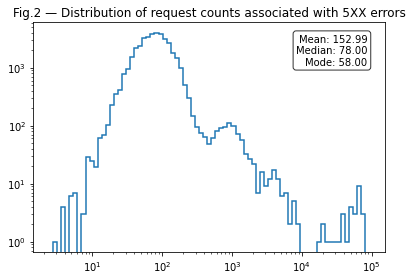

Saved Fig.2 -> userData/pivoted_paper_baseline_timesnet_viz/fig2_5xx_distribution_timesnet_like_gru.png


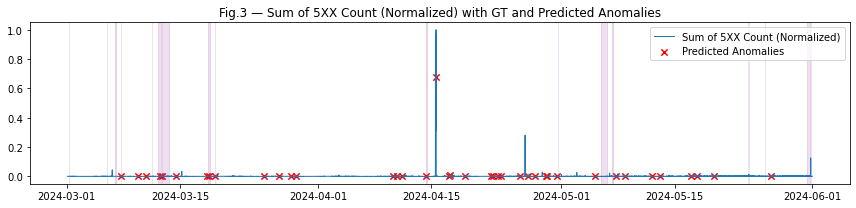

Saved Fig.3 -> userData/pivoted_paper_baseline_timesnet_viz/fig3_sum5xx_norm_with_alerts_timesnet.png


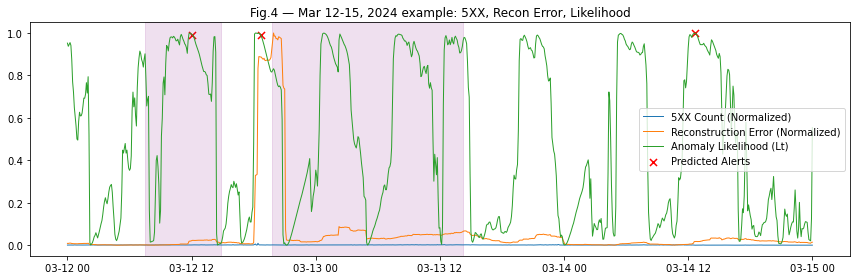

Saved Fig.4 -> userData/pivoted_paper_baseline_timesnet_viz/fig4_mar12_15_timesnet.png


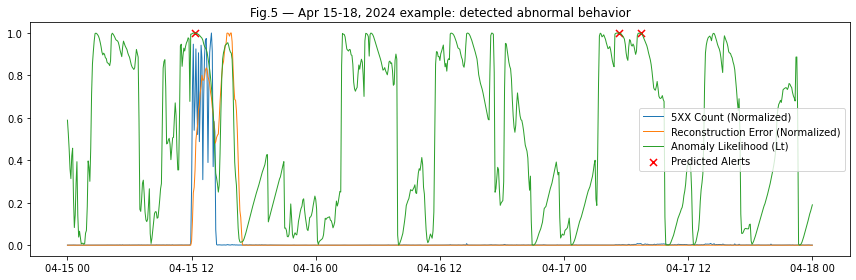

Saved Fig.5 -> userData/pivoted_paper_baseline_timesnet_viz/fig5_apr15_18_timesnet.png


/home/apps/anaconda3_2018/4.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:199: MatplotlibDeprecationWarning: SymmetricalLogScale got an unexpected keyword argument 'linthresh'. In the future this will raise TypeError


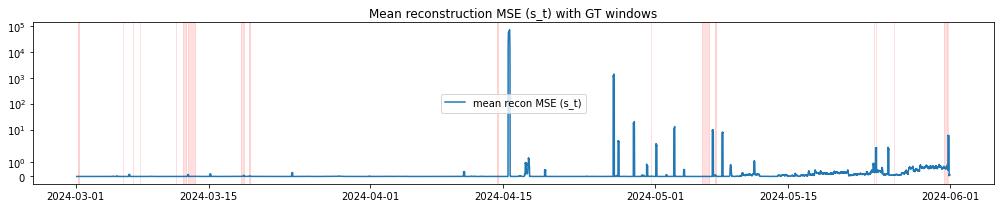

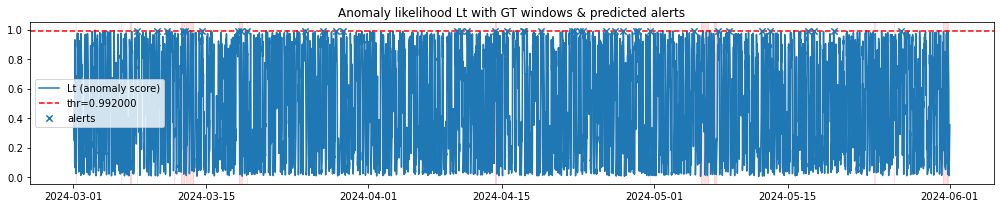


All figures saved to userData/pivoted_paper_baseline_timesnet_viz
Done (GRU-style visuals restored).


In [27]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

print("\nGenerating GRU-style visualizations (exactly like improved GRU)...")

s_arr = np.asarray(s_t).copy()           
L_raw_local = np.asarray(L_raw).copy()    
timestamps_local = pd.to_datetime(seq_timestamps)
try:
    timestamps_local = timestamps_local.tz_localize(None)
except Exception:
    pass
minlen = min(len(s_arr), len(L_raw_local), len(timestamps_local))
s_arr = s_arr[:minlen]
L_raw_local = L_raw_local[:minlen]
timestamps_local = timestamps_local[:minlen]

mse_series = pd.Series(s_arr, index=timestamps_local)
lt_series  = pd.Series(L_raw_local, index=timestamps_local)


if ('df' in globals()) and ('sum_5xx_count' in df.columns):
    sum_5xx = df['sum_5xx_count'].loc[timestamps_local[0]:timestamps_local[-1]].fillna(0)
    sum_norm = (sum_5xx - sum_5xx.min()) / (sum_5xx.max() - sum_5xx.min() + 1e-12)
else:
    sum_norm = pd.Series([], dtype=float)


def ema(x, alpha):
    out = np.empty_like(x, dtype=float)
    acc = 0.0
    for i, v in enumerate(x):
        acc = alpha * v + (1 - alpha) * acc if i else v
        out[i] = acc
    return out

def shaped_alerts(Ls, thr, cd, k_of_m=(2,3)):
    k, m = k_of_m
    above = (Ls >= thr)
    n = len(above)
    persisted = np.zeros_like(above, dtype=bool)
    for i in range(n):
        persisted[i] = (above[max(0, i-m+1):i+1].sum() >= k)
    trig = np.zeros_like(above, dtype=bool)
    i = 0
    while i < n:
        if persisted[i]:
            trig[i] = True
            i += cd
        else:
            i += 1
    return trig


VAL_START, VAL_END = pd.Timestamp("2024-03-01"), pd.Timestamp("2024-03-15 23:59:59")
tidx_arr = np.array(timestamps_local)
val_mask = (tidx_arr >= np.datetime64(VAL_START)) & (tidx_arr <= np.datetime64(VAL_END))
t_val = tidx_arr[val_mask]

gt_val = (gt_in_test if 'gt_in_test' in globals() else gt_df).copy()
if len(t_val)>0:
    gt_val = gt_val[(gt_val['anomaly_end'] >= pd.Timestamp(t_val[0])) & (gt_val['anomaly_start'] <= pd.Timestamp(t_val[-1]))].reset_index(drop=True)
else:
    gt_val = gt_val.iloc[0:0]


best = {"score": -1}
for alpha in [0.2, 0.3, 0.5]:
    Ls = ema(L_raw_local, alpha)
    L_val = Ls[val_mask] if len(val_mask)>0 else np.array([])
    for k_of_m in [(2,3), (3,5)]:
        for cd in [12, 24, 36, 72]:
            for thr in np.linspace(0.992, 0.9999, 20):
                if len(L_val)==0:
                    continue
                pred_val = shaped_alerts(L_val, thr, cd, k_of_m)
                s, _ = nab_score_from_mask(pred_val, gt_val, pd.to_datetime(t_val), profile='standard', event_gap_minutes=cd, pct_prob=PCT_PROB)
                if s > best["score"]:
                    best = {"score": s, "alpha": alpha, "k_of_m": k_of_m, "cd": cd, "thr": thr}
if best["score"] < 0:
   
    try:
        PAPER_THR
        fallback_thr = PAPER_THR
    except NameError:
        fallback_thr = 0.9973
    best = {"alpha":0.3, "k_of_m":(2,3), "cd":24, "thr":fallback_thr}


L_s = ema(L_raw_local, best["alpha"])
pred_full_mask = shaped_alerts(L_s, best["thr"], best["cd"], best["k_of_m"])
pred_series_shaped = pd.Series(pred_full_mask.astype(int), index=timestamps_local)
events = mask_to_event_times(pred_full_mask, timestamps_local, event_gap_minutes=best["cd"], pct_prob=PCT_PROB)
scores_df_smoothed = pd.DataFrame({"timestamp": timestamps_local, "anomaly_score": L_s}).set_index("timestamp")


fig2_path = os.path.join(OUT_DIR, 'fig2_5xx_distribution_timesnet_like_gru.png')
counts = df['sum_5xx_count'].fillna(0).values if ('df' in globals() and 'sum_5xx_count' in df.columns) else np.array([])
plt.figure(figsize=(6,4))
if len(counts)>0:
    min_x = max(1, counts.min()+1)
    max_x = counts.max()+1
    bins = np.logspace(max(0, np.log10(min_x)-0.1), np.log10(max_x)+0.1, 80)
    plt.hist(counts + 1e-9, bins=bins, histtype='step', linewidth=1.5)
    plt.xscale('log'); plt.yscale('log')
    mean_v = counts.mean(); median_v = np.median(counts)
    try:
        mode_v = stats.mode(counts)[0][0]
    except Exception:
        mode_v = np.nan
    plt.gca().text(0.95, 0.95, f"Mean: {mean_v:.2f}\nMedian: {median_v:.2f}\nMode: {mode_v:.2f}",
                   transform=plt.gca().transAxes, va='top', ha='right', bbox=dict(boxstyle='round', fc='white', alpha=0.8))
plt.title('Fig.2 — Distribution of request counts associated with 5XX errors')
plt.tight_layout(); plt.savefig(fig2_path, dpi=150); plt.show()
print("Saved Fig.2 ->", fig2_path)


fig3_path = os.path.join(OUT_DIR, 'fig3_sum5xx_norm_with_alerts_timesnet.png')
plt.figure(figsize=(12,3)); ax = plt.gca()
if not sum_norm.empty:
    ax.plot(sum_norm.index, sum_norm.values, label='Sum of 5XX Count (Normalized)', linewidth=1)

gt_to_draw = gt_in_test if 'gt_in_test' in globals() else (gt_df if 'gt_df' in globals() else None)
if gt_to_draw is not None and not gt_to_draw.empty:
    for _, r in gt_to_draw.iterrows():
        s = pd.to_datetime(r['anomaly_start']).tz_localize(None) if hasattr(r['anomaly_start'],'tz') else pd.to_datetime(r['anomaly_start'])
        e = pd.to_datetime(r['anomaly_end']).tz_localize(None) if hasattr(r['anomaly_end'],'tz') else pd.to_datetime(r['anomaly_end'])
        ax.axvspan(s, e, color='purple', alpha=0.12)

if len(events):
    ev_idx = pd.to_datetime(events)
    try:
        interp_vals = np.interp(ev_idx.astype('int64'), sum_norm.index.astype('int64'), sum_norm.values)
        plt.scatter(ev_idx, interp_vals, marker='x', color='red', s=40, label='Predicted Anomalies')
    except Exception:
        plt.scatter(ev_idx, [0]*len(ev_idx), marker='x', color='red', s=40, label='Predicted Anomalies')
plt.title('Fig.3 — Sum of 5XX Count (Normalized) with GT and Predicted Anomalies')
plt.legend(loc='upper right'); plt.tight_layout(); plt.savefig(fig3_path, dpi=150); plt.show()
print("Saved Fig.3 ->", fig3_path)


fig4_path = os.path.join(OUT_DIR, 'fig4_mar12_15_timesnet.png')
start4 = pd.Timestamp("2024-03-12"); end4 = pd.Timestamp("2024-03-15")
ix_sum = sum_norm.loc[start4:end4] if not sum_norm.empty else pd.Series([], dtype=float)
ix_mse = mse_series.loc[start4:end4] if not mse_series.empty else pd.Series([], dtype=float)
ix_lt  = lt_series.loc[start4:end4]  if not lt_series.empty else pd.Series([], dtype=float)
plt.figure(figsize=(12,4)); ax = plt.gca()
if not ix_sum.empty: ax.plot(ix_sum.index, ix_sum.values, label='5XX Count (Normalized)', linewidth=1)
if not ix_mse.empty: ax.plot(ix_mse.index, (ix_mse - ix_mse.min())/(ix_mse.max()-ix_mse.min()+1e-12), label='Reconstruction Error (Normalized)', linewidth=1)
if not ix_lt.empty:  ax.plot(ix_lt.index, ix_lt.values, label='Anomaly Likelihood (Lt)', linewidth=1)
ev_win = [e for e in events if (e >= start4) and (e <= end4)]
if len(ev_win) and not ix_lt.empty:
    vals = np.interp(pd.to_datetime(ev_win).astype('int64'), ix_lt.index.astype('int64'), ix_lt.values)
    plt.scatter(ev_win, vals, marker='x', color='red', s=50, label='Predicted Alerts')

if gt_to_draw is not None and not gt_to_draw.empty:
    ix_gt = gt_to_draw[(gt_to_draw['anomaly_start'] >= start4) & (gt_to_draw['anomaly_start'] <= end4)]
    for _, r in ix_gt.iterrows():
        s = pd.to_datetime(r['anomaly_start']).tz_localize(None) if hasattr(r['anomaly_start'],'tz') else pd.to_datetime(r['anomaly_start'])
        e = pd.to_datetime(r['anomaly_end']).tz_localize(None) if hasattr(r['anomaly_end'],'tz') else pd.to_datetime(r['anomaly_end'])
        ax.axvspan(s,e,color='purple',alpha=0.12)
plt.title('Fig.4 — Mar 12-15, 2024 example: 5XX, Recon Error, Likelihood'); plt.legend(); plt.tight_layout(); plt.savefig(fig4_path, dpi=150); plt.show()
print("Saved Fig.4 ->", fig4_path)


fig5_path = os.path.join(OUT_DIR, 'fig5_apr15_18_timesnet.png')
start5 = pd.Timestamp("2024-04-15"); end5 = pd.Timestamp("2024-04-18")
ix_sum = sum_norm.loc[start5:end5] if not sum_norm.empty else pd.Series([], dtype=float)
ix_mse = mse_series.loc[start5:end5] if not mse_series.empty else pd.Series([], dtype=float)
ix_lt  = lt_series.loc[start5:end5]  if not lt_series.empty else pd.Series([], dtype=float)
plt.figure(figsize=(12,4)); ax = plt.gca()
if not ix_sum.empty: ax.plot(ix_sum.index, ix_sum.values, label='5XX Count (Normalized)', linewidth=1)
if not ix_mse.empty: ax.plot(ix_mse.index, (ix_mse - ix_mse.min())/(ix_mse.max()-ix_mse.min()+1e-12), label='Reconstruction Error (Normalized)', linewidth=1)
if not ix_lt.empty:  ax.plot(ix_lt.index, ix_lt.values, label='Anomaly Likelihood (Lt)', linewidth=1)
ev_win = [e for e in events if (e >= start5) and (e <= end5)]
if len(ev_win) and not ix_lt.empty:
    vals = np.interp(pd.to_datetime(ev_win).astype('int64'), ix_lt.index.astype('int64'), ix_lt.values)
    plt.scatter(ev_win, vals, marker='x', color='red', s=50, label='Predicted Alerts')
if gt_to_draw is not None and not gt_to_draw.empty:
    ix_gt = gt_to_draw[(gt_to_draw['anomaly_start'] >= start5) & (gt_to_draw['anomaly_start'] <= end5)]
    for _, r in ix_gt.iterrows():
        s = pd.to_datetime(r['anomaly_start']).tz_localize(None) if hasattr(r['anomaly_start'],'tz') else pd.to_datetime(r['anomaly_start'])
        e = pd.to_datetime(r['anomaly_end']).tz_localize(None) if hasattr(r['anomaly_end'],'tz') else pd.to_datetime(r['anomaly_end'])
        ax.axvspan(s,e,color='purple',alpha=0.12)
plt.title('Fig.5 — Apr 15-18, 2024 example: detected abnormal behavior'); plt.legend(); plt.tight_layout(); plt.savefig(fig5_path, dpi=150); plt.show()
print("Saved Fig.5 ->", fig5_path)


try:
    plt.figure(figsize=(14,3))
    plt.plot(mse_series, label='mean recon MSE (s_t)')
    if gt_to_draw is not None and not gt_to_draw.empty:
        for _, r in gt_to_draw.iterrows():
            s = pd.to_datetime(r['anomaly_start']).tz_localize(None) if hasattr(r['anomaly_start'],'tz') else pd.to_datetime(r['anomaly_start'])
            e = pd.to_datetime(r['anomaly_end']).tz_localize(None) if hasattr(r['anomaly_end'],'tz') else pd.to_datetime(r['anomaly_end'])
            plt.axvspan(s,e,color='red', alpha=0.12)
    plt.yscale('symlog', linthresh=1e-6)
    plt.title('Mean reconstruction MSE (s_t) with GT windows'); plt.legend(); plt.tight_layout()
    plt.show()
except Exception as e:
    print('MSE plot error (ignored):', e)

try:
    plt.figure(figsize=(14,3))
    plt.plot(scores_df_smoothed.index, scores_df_smoothed['anomaly_score'], label='Lt (anomaly score)')
    plt.axhline(best["thr"], color='red', linestyle='--', label=f'thr={best["thr"]:.6f}')
    if gt_to_draw is not None and not gt_to_draw.empty:
        for _, r in gt_to_draw.iterrows():
            s = pd.to_datetime(r['anomaly_start']).tz_localize(None) if hasattr(r['anomaly_start'],'tz') else pd.to_datetime(r['anomaly_start'])
            e = pd.to_datetime(r['anomaly_end']).tz_localize(None) if hasattr(r['anomaly_end'],'tz') else pd.to_datetime(r['anomaly_end'])
            plt.axvspan(s, e, color='red', alpha=0.12)
    ev_dt = pd.to_datetime(events)
    if len(ev_dt):
        plt.scatter(ev_dt, [best["thr"]]*len(ev_dt), marker='x', s=40, label='alerts', zorder=5)
    plt.title('Anomaly likelihood Lt with GT windows & predicted alerts')
    plt.legend(); plt.tight_layout(); plt.show()
except Exception as e:
    print('Score plot error (ignored):', e)

print("\nAll figures saved to", OUT_DIR)
print("Done (GRU-style visuals restored).")
